# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by **concatenating character images** from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to **five digits, and use five classifiers on top of your deep network**. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

==============================================================================================
# My strategy:
1. Import mnist dataset and build a neural network.
2. Generate blank character and mix with real character, build a binary classifier to predict whether it is a digit.
3. Combine binary classifier and network classifier to recognize the possible single digit. 
4. Generate 2-digit synthetic dataset from MNIST, optimize model to make it work.
5. Generate 5-digit synthetic datase and modify model.

## step 1, build binary classifier, check mnist data
1. import mnist data organized by michael nielsen, check data and random data
2. use Tensorflow build a simple network with relu and L2,  

In [1]:
from six.moves import cPickle 
import gzip
with gzip.open('mnist.pkl.gz', 'rb') as f:
    training_data, validation_data, test_data = cPickle.load(f)
[X_train, y_train] = training_data
[X_valid, y_valid] = validation_data
[X_test, y_test] = test_data

# convert labels to 1-hot encoding
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

def oneHot(lables):
  return (np.arange(10) == lables[:,None]).astype(np.float32)

y_train, y_valid, y_test = oneHot(y_train), oneHot(y_valid), oneHot(y_test)
print X_train.shape, y_train.shape

(50000, 784) (50000, 10)


### 784\*100\*10 network, relu hidden layer

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential([
    Dense(100, input_dim=784),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#from keras.optimizers import SGD
#model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
model.fit(X_train, y_train, nb_epoch=10, batch_size=32)
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
#classes = model.predict_classes(X_test, batch_size=32)

Epoch 1/10
50000/50000 [==============================] - 4s - loss: 0.7220 - acc: 0.8205     
Epoch 2/10
50000/50000 [==============================] - 4s - loss: 0.3611 - acc: 0.9009     
Epoch 3/10
50000/50000 [==============================] - 4s - loss: 0.3077 - acc: 0.9142     
Epoch 4/10
50000/50000 [==============================] - 4s - loss: 0.2767 - acc: 0.9225     
Epoch 5/10
50000/50000 [==============================] - 4s - loss: 0.2536 - acc: 0.9293     
Epoch 6/10
50000/50000 [==============================] - 4s - loss: 0.2349 - acc: 0.9340     
Epoch 7/10
50000/50000 [==============================] - 4s - loss: 0.2192 - acc: 0.9387     
Epoch 8/10
50000/50000 [==============================] - 4s - loss: 0.2053 - acc: 0.9424     
Epoch 9/10
50000/50000 [==============================] - 4s - loss: 0.1931 - acc: 0.9457     
Epoch 10/10
 9856/10000 [============================>.] - ETA: 0s

## step 2,  generate blank/valid dataset, build binary classifier
1. dataset size: 10k/10k
2. use sklearn classifier to check data

In [57]:
nb_rows = 20000
imag_size = 28*28
dataset = np.ndarray((nb_rows, imag_size), dtype=np.float32)
labels = np.ndarray(nb_rows, dtype=np.int32)
# generate blank dagtaset
for i in range(10000):
  dataset[i] = np.random.rand(imag_size)
  labels[i] = 0
# generate valid dataset  
for i in range(10000,20000):
  index = np.random.randint(50000)
  dataset[i] = X_train[index]
  labels[i] = 1

In [58]:
# use Logistic Regression to train and get accuracy
from sklearn.model_selection import train_test_split
X1, X2,y1,y2 = train_test_split(dataset, labels, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(X1, y1)
print(clf.score(X2, y2))

1.0


## step 3, Combine binary classifier and network classifier to recognize the possible single digit. 

In [59]:
for i in range(10):
  index = np.random.randint(20000)
  exist = clf.predict(dataset[index])
  if exist[0] == 1:
    pred = model.predict_classes(dataset[index:index+1], verbose = 0)
    print 'index = {0:5g}, predict = {1}'.format(index,pred[0])
  else:
    print 'index = {0:5g}, predict = {1}'.format(index,None)

index = 19146, predict = 5
index =  1411, predict = None
index = 15317, predict = 9
index = 12051, predict = 4
index =  8715, predict = None
index =  3862, predict = None
index =  6658, predict = None
index = 14684, predict = 9
index = 16222, predict = 8
index = 11485, predict = 5


## step 4, Generate 2-digit synthetic dataset from MNIST, optimize model to make it work.
1. dataset size: 1 k
2. check accuracy

In [60]:
num_rows= 1000
num_digits = 2
imag_size = 28*28
dataset_2d = np.ndarray((num_rows,num_digits, imag_size), dtype=np.float32)
labels_2d = np.ones((num_rows,num_digits),dtype = int)*10

for i in range(num_rows):
  for j in range(num_digits):
    dice = np.random.randint(11) # throw dice to decide which to include
    if dice == 10:
      dataset_2d[i][j] = np.random.rand(imag_size)
    else:
      index = np.random.randint(50000)
      dataset_2d[i][j] = X_train[index]
      labels_2d[i][j]= np.argmax(y_train[index],0)

In [61]:
result =[]  # 
for i in range(num_rows):
  predit = [10 for _ in range(num_digits)]  # set default to 10 (represent None)
  for j in range(num_digits):
    data =dataset_2d[i,j]
    exist = clf.predict(data)
    if exist[0]:
      predit[j] = model.predict_classes(data.reshape((1,784)), verbose = 0)[0]
  #print predit, labels_2d[i]
  if (predit == labels_2d[i]).all():
    result.append(True)
  else:
    result.append(False)
  if i % 100== 0:
    print i, np.mean(result)

print "accuracy = {}".format(np.mean(result)) 

0 1.0
100 0.891089108911
200 0.89552238806
300 0.893687707641
400 0.902743142145
500 0.908183632735
600 0.915141430948
700 0.914407988588
800 0.911360799001
900 0.907880133185
accuracy = 0.903


## Step 5, Generate 5-digit synthetic datase and modify mode

In [62]:
num_rows = 100
num_digits = 5
imag_size = 28*28
dataset_5d = np.ndarray((num_rows,num_digits, imag_size), dtype=np.float32)
labels_5d = np.ones((num_rows,num_digits),dtype = int)*10

for i in range(num_rows):
  for j in range(num_digits):
    dice = np.random.randint(11)
    if dice == 10:
      dataset_5d[i][j] = np.random.rand(imag_size)
    else:
      index = np.random.randint(50000)
      dataset_5d[i][j] = X_train[index]
      labels_5d[i][j]= np.argmax(y_train[index],0)

In [64]:
result =[]
for i in range(num_rows):
  predit = [10 for _ in range(num_digits)]
  for j in range(num_digits):
    data =dataset_5d[i,j]
    exist = clf.predict(data)
    if exist[0]:
      predit[j] = model.predict_classes(data.reshape((1,784)), verbose = 0)[0]
  if (predit == labels_5d[i]).all():
    result.append(True)
  else:
    result.append(False)
  if i % 10== 9:
    print i, np.mean(result)

print "accuracy = {}".format(np.mean(result)) 

9 0.8
19 0.85
29 0.733333333333
39 0.725
49 0.78
59 0.8
69 0.8
79 0.7875
89 0.8
99 0.81
accuracy = 0.81


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:**  My strategy:
1. Import mnist dataset and build a neural network.
2. Generate blank character and mix with real character, build a binary classifier to predict whether it is a digit.
3. Combine binary classifier and network classifier to recognize the possible single digit. 
4. Generate 2-digit synthetic dataset from MNIST, optimize model to make it work.
5. Generate 5-digit synthetic datase and modify model.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** My final architecture is a logistic regression binary classifier on top of a single-hidden layer neural network. 
- input size is 784
- single hidden layer is Relu layer with 100 neurons
- fully connectivity

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** 
- the blank/valid binary classifier and number recognition classifier are trained seperately
- Use a 10:1 ratio to generate valid/blank digits to train the binary classifier

shape =(28, 56)
lables=[7 4]


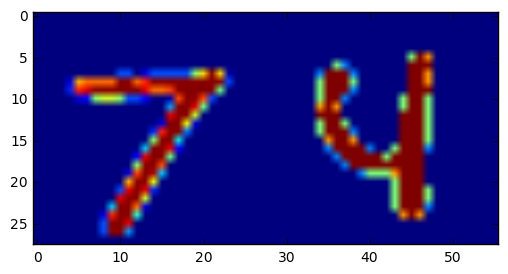

In [65]:
sample_idx = np.random.randint(num_rows)  # pick a random image index
a = dataset_2d[sample_idx,0].reshape(28,28)
b = dataset_2d[sample_idx,1].reshape(28,28)
sample_image = np.concatenate((a,b),axis=1) # extract a 2D slice
print 'shape ={0}'.format(sample_image.shape)
print 'lables={0}'.format(labels_2d[sample_idx])
plt.figure()
plt.imshow(sample_image)  # display it

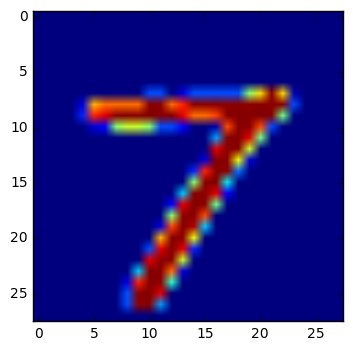

In [66]:
plt.figure()
plt.imshow(np.hsplit(sample_image,2)[0])  # display it

In [67]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
c = np.concatenate((a,b),axis=1)
print c
print np.hsplit(c,2)

[[1 2 5 6]
 [3 4 7 8]]
[array([[1, 2],
       [3, 4]]), array([[5, 6],
       [7, 8]])]


shape =(28, 140)
lables=[ 1  3 10  7  4]


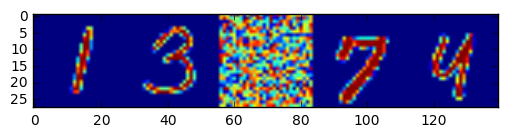

In [73]:
sample_idx = np.random.randint(num_rows)  # pick a random image index
a = dataset_5d[sample_idx,0].reshape(28,28)
b = dataset_5d[sample_idx,1].reshape(28,28)
c = dataset_5d[sample_idx,2].reshape(28,28)
d = dataset_5d[sample_idx,3].reshape(28,28)
e = dataset_5d[sample_idx,4].reshape(28,28)
sample_image = np.concatenate((a,b,c,d,e),axis=1) # extract a 2D slice
print 'shape ={0}'.format(sample_image.shape)
print 'lables={0}'.format(labels_5d[sample_idx])
plt.figure()
plt.imshow(sample_image)  # display it

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
import numpy as np
import cPickle as pickle
with open('train_dataset_labels.pickle','rb') as f:
  X_train,y_train = pickle.load(f)
with open('test_dataset_labels.pickle','rb') as f:
  X_test,y_test = pickle.load(f)

def oneHot(lables):
  return (np.arange(10) == lables[:,None]).astype(np.float32)
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

y_train, y_test = oneHot(y_train), oneHot(y_test)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential([
    Dense(100, input_dim=784),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#from keras.optimizers import SGD
#model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
model.fit(X_train, y_train, nb_epoch=10, batch_size=32)
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
#classes = model.predict_classes(X_test, batch_size=32)

Using TensorFlow backend.


Epoch 1/10
73257/73257 [==============================] - 5s - loss: 2.0124 - acc: 0.3062     
Epoch 2/10
73257/73257 [==============================] - 4s - loss: 1.5311 - acc: 0.5540     
Epoch 3/10
73257/73257 [==============================] - 4s - loss: 1.2583 - acc: 0.6545     
Epoch 4/10
73257/73257 [==============================] - 4s - loss: 1.1175 - acc: 0.6915     
Epoch 5/10
73257/73257 [==============================] - 4s - loss: 1.0332 - acc: 0.7128     
Epoch 6/10
73257/73257 [==============================] - 4s - loss: 0.9750 - acc: 0.7256     
Epoch 7/10
73257/73257 [==============================] - 4s - loss: 0.9305 - acc: 0.7370     
Epoch 8/10
73257/73257 [==============================] - 4s - loss: 0.8933 - acc: 0.7460     
Epoch 9/10
73257/73257 [==============================] - 4s - loss: 0.8603 - acc: 0.7560     
Epoch 10/10
24352/26032 [===========================>..] - ETA: 0s

In [8]:
24352/26032.0  # I feel too lucky!

0.9354640442532268

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**
### data setup:  I have tried both formats of data. 
#### format 1

take train.tar.gz for example:

1. after unzipping, get a "train" folder with 33.402 k png files and 1 digitStruct.mat file, totaling 626 MB. 
2. Use matlab open the .mat file, get 1*33402 struct. Each struct has 2 fields: name and bbox. name is for png file. bbox is the pixel position of the blue box, which is represent by a struct with 5 fields: height, left, top, width, label. 
3. Note that the bboxes don't have a fixed size. So we have to use cv2 to resize it. The bunch of codes is in the accompany ipynb file.
4. Machine learning data is usually in the 2D-shape (num, featuers), but why image data is typical stored in 3D-shape: (num, n_x, n_y)  or even 4D-shape (num,n_x,n_y,3) ? 1st, it is easier to extract individual pixel or a rectangle block of pixels. 2nd, it is natural to show the image by `matplotlib.pyplot.imshow(image)`

#### format 2

The images are 90% preprocessed. The mat file in format 1 is HDF5 format, but the mat file in format 2 is not. So `scipy.io.loadmat` can easily handle the work.  Besides the format, the major difference is actually the content. In format 2, the image are strictly cropped by 32\*32 pixels. As a result, the adjecent numbers become the background noise to the target number. So I would expect the identification accuracy may decrease. 


### model performance
for single hidden layer net, using format 2, I run three times and get 99.6%, 99.4% and 93.5% testing accuracy, respectively. 

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** options explored to improve results:
1. use bette quality data: format 1 vs format 2
2. single hidden layer neural network is far better than shallow machine learning like logistic regression and SVM
3. Convolutional neural network is even better. It just cost too much computer power and time.
4. In my first submission, I used TensorFlow, which actually cost me a lot of time to get familar its usage and fine tune the hyperparameter. This time I use Keras, which has TensorFlow as backend. Keras is much more convinient to use. A life saver.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** 
- initial result is 60% accuracy, final result is 93 %
- I think it's good enough. But I have to check its validity if I have more time.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [33]:
import cv2

def convert(png):
  rgb = cv2.imread(png)
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  resized = cv2.resize(gray,(28,28))
  scaled = resized/255.0 -0.5
  return scaled

paths = ['example/1.png', 'example/2.jpg','example/3.png','example/6.png','example/9.png']

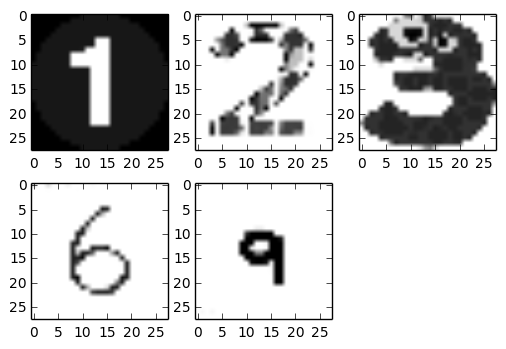

In [62]:
from matplotlib import pyplot as plt
% matplotlib inline
images = np.zeros((5,784))
plt.figure(1) 
for i,path in enumerate(paths):
  image = convert(path)              
  plt.subplot(231+i)
  plt.imshow(image,cmap='gray')
  images[i,:] = image.reshape(784,)
  del image
  

In [65]:
# predict
model.predict_classes(images,verbose=False)

array([1, 2, 3, 6, 8])

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:** It is quite exciting to use some captured images to test my model. Basically, I have 2 sources to get images. 
- shot by iphone 5s and airdrop to mac as jpg file. However, when I use opencv to imread and convert it to grayscale. These images are discontinuous, even difficult for human eye to recognize. I guess these jpg files are special coded, which causes problem when converting into arrays. 
- download from internet, some images have special effect, which may fool the prediction model. It turns out, the normal images can be easily recognized, the special effect images can't be. 

So the image quality still matters a lot. 

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**  4 out of 5 images are predicted correctly. This means 80% accuracy. I won't say it perform equally well. the image quality is quite different. And the number of sample is too small to have a fair comparison.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** A workflow from image to final identification is:
1. use camera to capture a real world image
2. store this image in png or jpg format
3. use opencv.imread() to convert png file to 3d numpy array
4. convert to 2d numpy array (greyscale)
5. use opencv.resize() to resize it to a 28 * 28 array
6. normalize the values in the range of [-0.5,0.5]
7. use pre-train neural network model to predict the result

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a **localizer**. Train a **regression loss** to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

---
I am not sure the correct way to contruct a localizer. My thought process is:
1. the localizer has an input layer of a fix-size 28*28 nuerons, output layer is a binary classifier. 
2. use 28*28 single-digit images as well as 28*28 blank images to train the model
3. For an arbitrary size images, if either the width or the height is smaller than 28, mark this image as negative: no digit. So we assume the localizer works in a large enough image. Use the localizer as a  **local receptive field** of the convolutional layer, move it block by block to capture the possible digits.

My question is: this localizer is a fix size, which seems not satisfy the question asked. Do you have any suggestions?



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.


### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.